# Deep Learning Final Exam

## Mesyella/2201793281

### 1. News Category Classification using BERT 

disini saya membuat model deep learning untuk mengkategorikan berita berbahasa indonesia ke dalam 2 kategori yaitu culture dan kesehatan menggunakan indoBert dari transformer huggingface

*apabila menjalankan melalui google colab harap masukkan news.csv dan membuat folder bernama Data*

### A. Code 

### Install Library Transformer

Untuk menggunakan pre-trained model BERT, kita perlu menginstall library transformer yang berasal dari huggingface.

In [1]:
!pip install transformers

### Import library yang dibutuhkan

lalu kemudian saya mengimport library-library yang dibutuhkan untuk membuat news classification. Disini untuk model yang akan digunakan adalah BertForSequenceClassification dimana kita akan mengklasifikasi apakah sebuah sequence berita memiliki kategori culture atau kesehatan. Tokenizer yang digunakan juga berasal dari BERT yaitu BertTokenizer.

In [2]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch
import string
from sklearn.model_selection import train_test_split
# Preliminaries
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
# Training
import torch.optim as optim
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Code dibawah untuk menampilkan device yang digunakan apabila tersedia gpu maka akan menggunakan gpu apabila tidak maka menggunakan cpu

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Preprocessing Dataset

Untuk tokenizer, saya menggunakan 'indobert-base-uncased' dari indoNLU dimana model ini merupakan model bert untuk Bahasa Indonesia yang di trained menggunakan 220M kata dari wikipedia, artikel, dan web corpus. Model ini ditrain sebanyak 2.4M langkah (180 epochs). Dokumentasi dapat dilihat pada https://huggingface.co/indolem/indobert-base-uncased 

Saya menggunakan tokenizer dan model dari Indobert dikarenakan dataset yang digunakan adalah berita yang berbahasa indonesia yang dapat dilihat pada news.csv. Untuk train-test ratio saya menggunakan 0.6 dan train_valid ratio saya menggunakan 0.8 dimana ratio ini merupakan ratio dengan hasil terbaik setelah mencoba berbagai ratio lainnya.

In [4]:
tokenizer = BertTokenizer.from_pretrained("indolem/indobert-base-uncased")
path = 'news.csv'
train_test_ratio = 0.60
train_valid_ratio = 0.80

Untuk mempersiapkan data agar dapat sesuai dengan input yang dibutuhkan model, saya membuat function untuk preprocessing seperti menghilangkan tanda baca, mengubah seluruh huruf menjadi lowercase, dan melakukan split pada kata.

In [5]:
def preprocessing(x):
    x = x.lower()
    x = x.replace('.', ' ')
    x = x.translate(str.maketrans('','', string.punctuation))
    x = x.split()
    x = ' '.join(x[:])

    return x

Disini saya membaca data dari news.csv, membuat index baru yang menggabungkan title dan text, mengubah kategori menjadi 1 dan 0 dimana culture akan dianggap 1 dan kesehatan dianggap 0. Dan juga melakukan split data untuk train, test, dan validation.

Disini saya memastikan data culture dan data kesehatan akan memiliki jumlah yang seimbang pada train, test, dan validation agar model tidak akan condong ke salah satu kategori.

In [6]:
data = pd.read_csv(path)
data['category'] = (data['category'] == 'Culture').astype('int')
data['text'] = data['text'].apply(preprocessing)
data['title'] = data['title'].apply(preprocessing) 
data['titletext'] = data['title'] + ". " + data['text']
# data['length'] = data.titletext.str.len()
data = data.reindex(columns=['category', 'title', 'text', 'titletext'])
data_cult = data[data['category'] == 1]
data_kese = data[data['category'] == 0]

# Train-test split
df_cult_full_train, df_cult_test = train_test_split(data_cult, train_size = train_test_ratio, random_state = 1)
df_kese_full_train, df_kese_test = train_test_split(data_kese, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_cult_train, df_cult_valid = train_test_split(df_cult_full_train, train_size = train_valid_ratio, random_state = 1)
df_kese_train, df_kese_valid = train_test_split(df_kese_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_cult_train, df_kese_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_cult_valid, df_kese_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_cult_test, df_kese_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv( '/train.csv', index=False)
df_valid.to_csv('/valid.csv', index=False)
df_test.to_csv('/test.csv', index=False)

Untuk max sequence length yang digunakan adalah 205 karena jumlah kata dari berita yang terdapat pada dataset berkisar dari 205-1500. Kemudia data dipersiapkan untuk masuk ke dalam model

In [7]:
# Model parameter
MAX_SEQ_LEN = 205
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('category', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path='/', train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterator
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

### BERT Model

Kemudian untuk model yang digunakan juga berasal dari 'indobert-base-uncased' dari indoNLU dimana model ini merupakan model bert untuk Bahasa Indonesia yang di trained menggunakan 220M kata dari wikipedia, artikel, dan web corpus. Model ini ditrain sebanyak 2.4M langkah (180 epochs). Dokumentasi dapat dilihat pada https://huggingface.co/indolem/indobert-base-uncased

Pada function forward, dilakukan encoder untuk mengubah sequence kata yang ada menjadi vector representation. Vector ini kemudian akan digunakan untuk model klasifikasi.

In [8]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()  
        self.encoder = BertForSequenceClassification.from_pretrained("indolem/indobert-base-uncased")

    def forward(self, text, label): 
        loss, text_fea = self.encoder(text, labels=label)[:2]
        return loss, text_fea

### Training

Kemudian function dibawah ini untuk save model terbaik dengan membandingkan valid loss yang ada sehingga nantinya akan menghasilkan model dengan valid loss terkecil.

In [9]:
def save_checkpoint(save_path, model, valid_loss):
    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [10]:
# Training Function
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = 'Data',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, title, text, titletext), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

Selanjutnya untuk proses training, menggunakan model indoBert yang telah dibuat tadi dan optimizer menggunakan Adam dimana learning rate yang digunakan cukup kecil yaitu 4e-5 karena kita menggunakan model yang telah di train sebelumnya. Untuk criterion digunakan BCEloss (Binary CrossEntropy) karena disini kita melakukan binary classification. Training ini dilakukan sebanyak 10 epoch agar menghasilkan hasil yang cukup baik.

In [11]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=4e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indober

Epoch [1/10], Step [1/30], Train Loss: 0.6395, Valid Loss: 0.5868
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics.pt
Epoch [1/10], Step [2/30], Train Loss: 0.6530, Valid Loss: 0.6334
Epoch [1/10], Step [3/30], Train Loss: 0.8769, Valid Loss: 0.4959
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics.pt
Epoch [2/10], Step [4/30], Train Loss: 0.2497, Valid Loss: 0.4095
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics.pt
Epoch [2/10], Step [5/30], Train Loss: 0.3439, Valid Loss: 0.3844
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics.pt
Epoch [2/10], Step [6/30], Train Loss: 0.2914, Valid Loss: 0.3481
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics.pt
Epoch [3/10], Step [7/30], Train Loss: 0.1475, Valid Loss: 0.3139
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics.pt
Epoch [3/10], Step [8/30], Train Loss: 0.1989, Valid Loss: 0.2698
Model saved to ==> Data/model.pt
Model saved to ==> Data/metrics

### B. Analisa dari hasil pelatihan

Model loaded from <== Data/metrics.pt


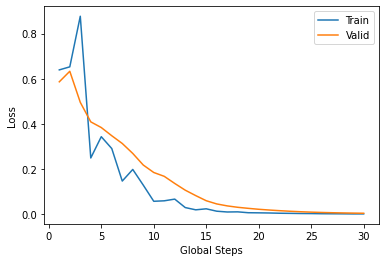

In [12]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('Data/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Dari hasil training yang telah dilakukan, valid loss dan training loss yang dapat dilihat pada grafik dibawah ini cukup baik hingga mendekati 0 dan tidak terdapat gap/jarak antara kedua grafik sehingga menandakan model ini dilatih cukup baik dan tidak menunjukan overfitting pada model ini.

In [13]:
# Evaluation Function
def evaluate(model, test_loader): 
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Kesehatan', 'Culture'])
    ax.yaxis.set_ticklabels(['Kesehatan', 'Culture'])

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indober

Model loaded from <== Data/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    0.9500    0.9744        20
           0     0.9524    1.0000    0.9756        20

    accuracy                         0.9750        40
   macro avg     0.9762    0.9750    0.9750        40
weighted avg     0.9762    0.9750    0.9750        40



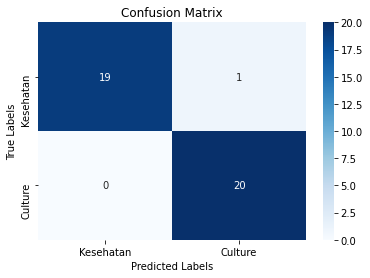

In [14]:
best_model = BERT().to(device)

load_checkpoint('Data/model.pt', best_model)

evaluate(best_model, test_iter)

Hasil yang didapatkan dari model ini sudah sangat baik dimana dari 40 data test hanya terdapat 1 data yang dikategorikan tidak sesuai. Akurasi yang didapatkan sudah sangat tinggi yaitu 97.5%. Oleh karena itu, model deep learning untuk mengklasifikasikan kategori dari berita berbahasa indonesia ini sudah berjalan sangat baik tanpa overfitting.

### C. Keunikan dari model deep learning

Model yang digunakan untuk klasifikasi kategori news yang berbahasa indonesia adalah model pre-trained dari IndoBert yaitu 'indobert-base-uncased' dari indoNLU (huggingface) dimana model ini merupakan model bert untuk Bahasa Indonesia yang di trained menggunakan 220M kata dari wikipedia, artikel, dan web corpus. Model ini ditrain sebanyak 2.4M langkah (180 epochs). 

BERT (Bidirectional Encoder Representations from Transformers) merupakan transfer learning yang menggunakan mekanisme attention yang mempelajari hubungan kontekstual antara kata di text. Kata pada text diubah menjadi vector yang kemudian di proses menggunakan neural network.

Model ini sudah sangat sesuai dengan kebutuhan klasifikasi berita ini dimana menghasilkan hasil yang sangat baik dengan accuracy 97.5%.